<a href="https://colab.research.google.com/github/denred0/simpsons_cnn/blob/main/vgg_simps_ons_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Feb 15 12:47:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


### Установка зависимостей

In [3]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.7.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.8.2+cu101)


In [4]:
!pip install "wheel==0.34.2"

In [5]:
# установка подходящей версии torch

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install torch==1.7.1+{accelerator} torchvision==0.8.2+{accelerator} torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [6]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [7]:
#!pip uninstall imgaug
!pip install imgaug==0.2.5

In [8]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
#!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

5.3.0


In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
#!unzip -q /content/gdrive/My\ Drive/datasets/simpsons/data/simpsons_dataset.zip -d train
!unzip -q /content/gdrive/My\ Drive/datasets/simpsons/data/new_simpsons_dataset.zip -d train
!unzip -q /content/gdrive/My\ Drive/datasets/simpsons/data/testset.zip -d test

replace train/new_simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
A
A
replace test/testset/img0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [11]:
!ls train

new_simpsons_dataset


В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [19]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from collections import Counter

import torch

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [20]:
!nvidia-smi
import torch
torch.cuda.is_available()



# работаем на видеокарте
if torch.cuda.is_available():
  DEVICE = torch.device("cuda")
else:
  DEVICE = torch.device("cpu")

Mon Feb 15 12:48:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
#DEVICE = torch.device("cpu")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [22]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 299
#RESCALE_SIZE = 224
#RESCALE_SIZE_TRAIN = 264

In [23]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    # __init__ вызывается при создании экземляра класса
    def __init__(self, files, mode):
        # super().__init__() вызывает конструктор родительского класса, чтобы 
        # можно было использовать его унаследованные методы, например, _len
        super().__init__() 
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            # self.files[0] PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg')
            # path  train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg
            # path.parent  train/simpsons_dataset/abraham_grampa_simpson
            # path.parent.name  abraham_grampa_simpson
            # получаем список лейблов-названий папок
            self.labels = [path.parent.name for path in self.files]
            # возвращает объект LabelEncoder() у которого есть поле le.classes_
            # в котором сохранен массив наших меток классов
            self.label_encoder.fit_transform(self.labels)

            # сохраняем метки классов
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def _prepare_sample(self, image):
        # ресайзим изображение и переводим в np array
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

    # def _prepare_sample_train(self, image):
    #     # ресайзим изображение и переводим в np array
    #     image = image.resize((RESCALE_SIZE_TRAIN, RESCALE_SIZE_TRAIN))
    #     return np.array(image)
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_val = transforms.Compose([
           # transforms.Resize([RESCALE_SIZE, RESCALE_SIZE])          
           
        ])

        transform_train = transforms.Compose([
            transforms.ColorJitter(brightness = np.abs(0.2 * torch.randn(1).item()), contrast = np.abs(0.2 * torch.randn(1).item()), 
                                    saturation = np.abs(0.2 * torch.randn(1).item())), #, hue = np.abs(0.1 * torch.randn(1).item())
            #transforms.Resize([RESCALE_SIZE, RESCALE_SIZE]), 
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
       #     transforms.RandomCrop(224),
            transforms.RandomRotation(20)
        ])

        transform = transforms.Compose([             
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        
        x = self.load_sample(self.files[index])

        # потом делим на 255, чтобы привести к значениям от 0 до 1. 
      #  x = np.array(np.array(x) / 255, dtype='float32')
        
        if self.mode == 'train':
          #x = self._prepare_sample_train(x)
          x = transform_train(x)
       
        # if self.mode in ['val', 'test']:
        #  # x = self._prepare_sample_val(x)
        #   x = transform_val(x)
        # получаем массив 224х224х3, где 3 - это количество каналов. Каждое значение в этот массиве значение вида [124, 234, 166], которое показывает цвет конкретного пикселя
        x = self._prepare_sample(x)
        # потом делим на 255, чтобы привести к значениям от 0 до 1. 
        x = np.array(x / 255, dtype='float32')
       # нормализуем
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            # возвращает индекс класса
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [24]:
np.abs(0.1 * torch.randn(1).item())

0.15756427049636842

In [25]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    mean = np.array([0.5, 0.5, 0.5])
    #std = np.array([0.229, 0.224, 0.225])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    # все, что меньше 0 становится = 0, что больше 1 становится равным 1
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [26]:
#TRAIN_DIR = Path('train/simpsons_dataset')
TRAIN_DIR = Path('train/new_simpsons_dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [27]:
#rain_val_files[0]

In [28]:
# for i, path in enumerate(train_val_files):
#   if i == 0:
#     print('path ', path)
#     print('path.parent ', path.parent)
#     print('path.parent.name ', path.parent.name)

In [29]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# train_val_labels = [path.parent.name for path in train_val_files]
# le.fit_transform(train_val_labels)
# # label = le.classes_[1]
# # label_id = le.transform([label])
# # label_id.item()
# # #le.transform(label)

In [30]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [31]:
len(val_files)

5268

In [32]:
len(train_files)

15804

In [33]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [34]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")
def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

In [35]:
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [36]:
# print_dct(dct_path_train)

In [37]:
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	685
agnes_skinner	32
apu_nahasapeemapetilon	467
barney_gumble	86
bart_simpson	1006
carl_carlson	73
charles_montgomery_burns	894
chief_wiggum	740
cletus_spuckler	49
comic_book_guy	352
disco_stu	15
edna_krabappel	343
fat_tony	20
gil	25
groundskeeper_willie	91
homer_simpson	1685
kent_brockman	374
krusty_the_clown	904
lenny_leonard	232
lionel_hutz	13
lisa_simpson	1016
maggie_simpson	97
marge_simpson	968
martin_prince	62
mayor_quimby	207
milhouse_van_houten	809
miss_hoover	13
moe_szyslak	1089
ned_flanders	1091
nelson_muntz	269
otto_mann	24
patty_bouvier	56
principal_skinner	895
professor_john_frink	62
rainier_wolfcastle	41
ralph_wiggum	67
selma_bouvier	77
sideshow_bob	658
sideshow_mel	34
snake_jailbird	41
troy_mcclure	6
waylon_smithers	136


In [38]:
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [39]:
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	894
chief_wiggum	740
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1685
kent_brockman	374
krusty_the_clown	904
lenny_leonard	232
lionel_hutz	100
lisa_simpson	1016
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	207
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1091
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [40]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

# выведим на печать класс:количесвто картинок для train должно быть примерно 75 %
print_dct(create_dct_from_labels(new_train_label))

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	894
chief_wiggum	740
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1685
kent_brockman	374
krusty_the_clown	904
lenny_leonard	232
lionel_hutz	100
lisa_simpson	1016
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	207
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1091
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [41]:
len(new_train_files)

16920

In [42]:
len(val_files)

5268

In [43]:
# image = Image.open(val_files[0])
# image.load()
# image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
# x = np.array(image)
# x = np.array(x / 255, dtype='float32')

# transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
#         ])
# transform(x).shape

In [44]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [45]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

In [46]:
train_dataset = SimpsonsDataset(new_train_files, mode='train')
#train_dataset = SimpsonsDataset(train_files, mode='train')

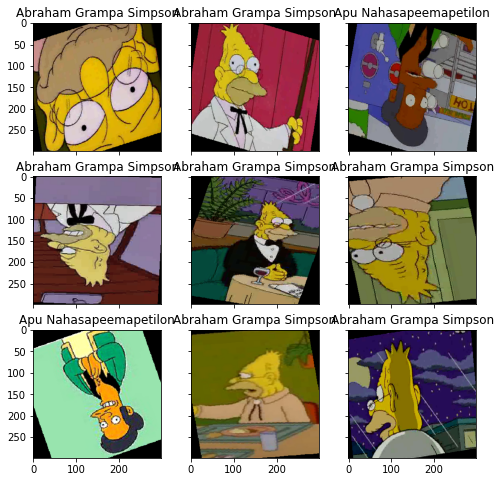

In [47]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)

for i, fig_x in enumerate(ax.flatten()):
    random_characters = int(np.random.uniform(0,1000)) #i
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    inp = im_val.numpy().transpose((1, 2, 0))
   # print(im_val[0])
   # print(inp[0])
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

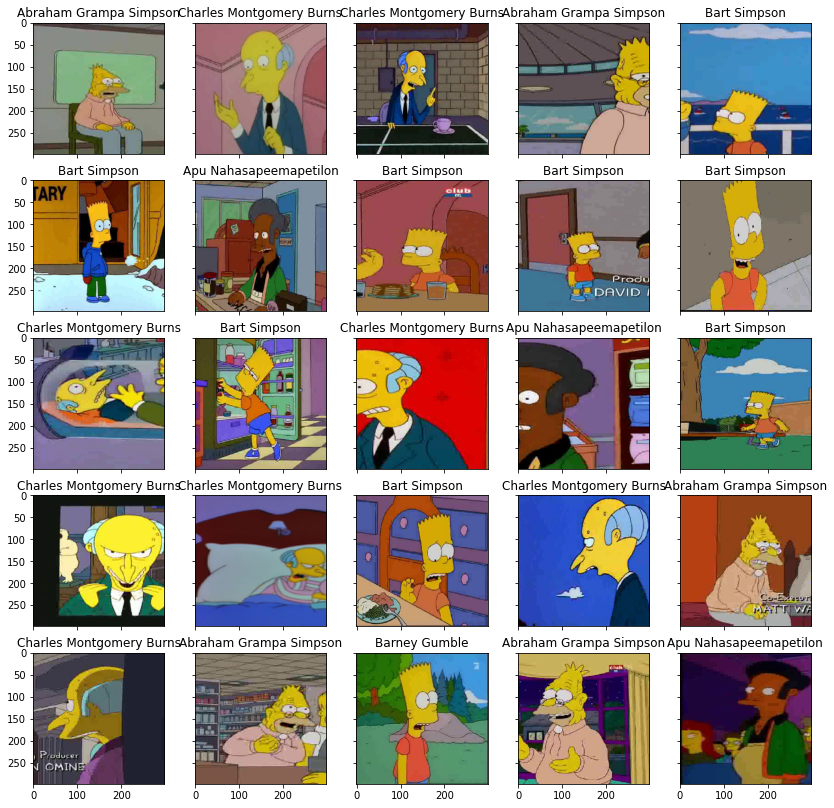

In [48]:
fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(14, 14), sharey=True, sharex=True)

for i, fig_x in enumerate(ax.flatten()):
    random_characters = int(np.random.uniform(0,1000)) #i
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    inp = im_val.numpy().transpose((1, 2, 0))
   # print(im_val[0])
   # print(inp[0])
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

In [49]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [50]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [51]:
def train(train_dataset, val_dataset, model, epochs, batch_size, opt, criterion):

    # перевожу в словарь, чтобы получить количество экземпляров каждого класса
    # на выходе получаю {'homer_simpson' : 15, 'march_simpson' : 56, ...}
    a = dict(Counter(train_dataset.labels))
    # достаю только значения из словаря
    class_sample_counts = list(a.values())
    # получаю веса каждого класса, список длинной 42 равный количеству классов
    weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)

    # получаю айдишники для каждой метки класса т.к. работать со стороковыми ключами не получится 
    le = preprocessing.LabelEncoder()
    ids = le.fit_transform(train_dataset.labels)
    # получаю список весов для каждого экземпляра класса 
    samples_weights = weights[ids]
    sampler = torch.utils.data.sampler.WeightedRandomSampler(
              weights=samples_weights,
              num_samples=len(samples_weights),
              replacement=True)
    
    min_val_loss = 10**6
    n_epochs_stop = 5
    epochs_no_improve = 0
    early_stop = False

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #shuffle=True shuffle не работает с sampler
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
       
     #   scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.2) # уменьшение lr на каждой эпохе на 0.5

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            #print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

           # scheduler.step()

          
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))


            if val_loss < min_val_loss:
                # Save the model
                #torch.save(model)
                epochs_no_improve = 0
                min_val_loss = val_loss
            else:
                epochs_no_improve += 1

                if epoch > 5 and epochs_no_improve == n_epochs_stop:
                    print('Early stopping!' )
                    early_stop = True
            
            if early_stop:
                print("Stopped")
                break


            
    return history

In [52]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [53]:
pip install pretrainedmodels

In [54]:
import pretrainedmodels
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [55]:
print(pretrainedmodels.pretrained_settings['inceptionv4'])

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth', 'input_space': 'RGB', 'input_size': [3, 299, 299], 'input_range': [0, 1], 'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5], 'num_classes': 1000}, 'imagenet+background': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth', 'input_space': 'RGB', 'input_size': [3, 299, 299], 'input_range': [0, 1], 'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5], 'num_classes': 1001}}


In [56]:
model_name = 'inceptionv4' # could be fbresnet152 or inceptionresnetv2
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
model.eval()

InceptionV4(
  (features): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Mixed_3a(
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): BasicConv2d(
        (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, mo

In [57]:
# for param in model.parameters():
#      param.requires_grad = False

In [58]:
# num_features = 4096
# n_classes = len(np.unique(train_val_labels))

# model.linear0 = nn.Linear(25088, 4096)
# model.relu0 = nn.ReLU(inplace=True)
# model.dropout0 = nn.Dropout(p=0.5, inplace=False)
# model.linear1 = nn.Linear(4096, 4096)
# model.relu1 = nn.ReLU(inplace=True)
# model.dropout1 = nn.Dropout(p=0.5, inplace=False)
# model.last_linear = nn.Sequential(
#                        nn.Linear(num_features, 256), 
#                        nn.ReLU(), 
#                        nn.Dropout(0.4),
#                        nn.Linear(256, n_classes),
#                         nn.LogSoftmax(dim = 1))

In [59]:
model

InceptionV4(
  (features): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Mixed_3a(
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): BasicConv2d(
        (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, mo

In [ ]:
# import torchvision.models as models
# #resnet18 = models.resnet18(pretrained=True)
# #alexnet = models.alexnet()
# #vgg16 = models.vgg16(pretrained=True)
# # squeezenet = models.squeezenet1_0()
# # densenet = models.densenet161()
# # inception = models.inception_v3()
# # googlenet = models.googlenet()
# # shufflenet = models.shufflenet_v2_x1_0()
# # mobilenet = models.mobilenet_v2()
# resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
# # wide_resnet50_2 = models.wide_resnet50_2()
# # mnasnet = models.mnasnet1_0()

In [41]:
for param in model.parameters():
    print(param.requires_grad)
    break

True


In [ ]:
# for param in model.parameters():
#     param.requires_grad = False

In [ ]:
# for param in model.parameters():
#     param.requires_grad = False

In [60]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 1536
n_classes = len(np.unique(train_val_labels))
# Заменяем Fully-Connected слой на наш линейный классификатор
#model.last_linear = nn.Linear(num_features, n_classes)
#model.fc = nn.Linear(num_features, n_classes)
model.last_linear = nn.Sequential(
                       nn.Linear(num_features, 1024), 
                       nn.ReLU(), 
                       nn.Linear(1024, 256), 
                       nn.ReLU(), 
                       nn.Dropout(0.4),
                       nn.Linear(256, n_classes),    
                       nn.LogSoftmax(dim = 1))

In [46]:
!nvidia-smi

Mon Feb 15 07:21:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [61]:
model

InceptionV4(
  (features): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Mixed_3a(
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): BasicConv2d(
        (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, mo

In [62]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

42,989,898 total parameters.
42,989,898 training parameters.


In [ ]:
# Очень простая сеть
# class SimpleCnn(nn.Module):
  
#     def __init__(self, n_classes):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
#             nn.ReLU(),
#             nn.BatchNorm2d(8),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
#             nn.ReLU(),
#             nn.BatchNorm2d(96),
#             nn.MaxPool2d(kernel_size=2)
#         )
        
#         self.out = nn.Linear(96 * 5 * 5, n_classes)
#         #conv_out = conv_out.view(conv_out.size(0), -1)

  
  
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.conv5(x)

#         x = x.view(x.size(0), -1)
#         logits = self.out(x)
#         return logits

In [ ]:
# n_classes = len(np.unique(train_val_labels))
# simple_cnn = SimpleCnn(n_classes).to(DEVICE)
# print("we will classify :{}".format(n_classes))
# print(simple_cnn)

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
# x = SimpsonsDataset(train_files, mode='train')
# from collections import Counter
# a = dict(Counter(x.labels))
# a
# class_sample_counts = list(a.values())
# class_sample_counts

In [ ]:
# weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
# weights

In [ ]:
# le = preprocessing.LabelEncoder()
# ids = le.fit_transform(x.labels)
# ids

In [ ]:
# samples_weights = weights[ids]

In [ ]:
# samples_weights

In [ ]:
# from torch.utils.data.sampler import WeightedRandomSampler

# sampler = torch.utils.data.sampler.WeightedRandomSampler(
#     weights=samples_weights,
#     num_samples=len(samples_weights),
#     replacement=True)

In [ ]:
# a.values()

In [63]:
import torch
torch.manual_seed(42)

In [46]:
!nvidia-smi

Mon Feb 15 09:35:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [65]:
model = model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00010, weight_decay = 0.0001)
criterion = nn.CrossEntropyLoss() 


history = train(train_dataset, val_dataset, model=model, epochs=50, batch_size=64, opt = optimizer, criterion = criterion)

epoch:   2%|▏         | 1/50 [07:50<6:24:10, 470.42s/it]


Epoch 001 train_loss: 2.1361 val_loss 1.3064 train_acc 0.3887 val_acc 0.6264


epoch:   4%|▍         | 2/50 [15:41<6:16:25, 470.52s/it]


Epoch 002 train_loss: 1.2992 val_loss 0.9191 train_acc 0.6485 val_acc 0.7756


epoch:   6%|▌         | 3/50 [23:32<6:08:40, 470.64s/it]


Epoch 003 train_loss: 0.8841 val_loss 0.6345 train_acc 0.7653 val_acc 0.8303


epoch:   8%|▊         | 4/50 [31:23<6:00:57, 470.83s/it]


Epoch 004 train_loss: 0.6283 val_loss 0.4706 train_acc 0.8270 val_acc 0.8778


epoch:  10%|█         | 5/50 [39:11<5:52:34, 470.10s/it]


Epoch 005 train_loss: 0.4703 val_loss 0.3631 train_acc 0.8704 val_acc 0.9098


epoch:  12%|█▏        | 6/50 [46:58<5:44:05, 469.21s/it]


Epoch 006 train_loss: 0.3292 val_loss 0.3321 train_acc 0.9099 val_acc 0.9273


epoch:  14%|█▍        | 7/50 [54:45<5:35:38, 468.35s/it]


Epoch 007 train_loss: 0.2682 val_loss 0.2502 train_acc 0.9287 val_acc 0.9372


epoch:  16%|█▌        | 8/50 [1:02:30<5:27:08, 467.35s/it]


Epoch 008 train_loss: 0.2024 val_loss 0.2358 train_acc 0.9462 val_acc 0.9459


epoch:  18%|█▊        | 9/50 [1:10:14<5:18:46, 466.49s/it]


Epoch 009 train_loss: 0.1808 val_loss 0.2019 train_acc 0.9514 val_acc 0.9518


epoch:  20%|██        | 10/50 [1:17:59<5:10:36, 465.91s/it]


Epoch 010 train_loss: 0.1662 val_loss 0.2402 train_acc 0.9570 val_acc 0.9427


epoch:  22%|██▏       | 11/50 [1:26:06<5:06:57, 472.24s/it]


Epoch 011 train_loss: 0.1504 val_loss 0.2017 train_acc 0.9606 val_acc 0.9575


epoch:  24%|██▍       | 12/50 [1:34:02<4:59:52, 473.48s/it]


Epoch 012 train_loss: 0.1466 val_loss 0.2082 train_acc 0.9618 val_acc 0.9524


epoch:  26%|██▌       | 13/50 [1:41:51<4:51:04, 472.01s/it]


Epoch 013 train_loss: 0.1210 val_loss 0.1737 train_acc 0.9678 val_acc 0.9626


epoch:  28%|██▊       | 14/50 [1:49:42<4:43:04, 471.78s/it]


Epoch 014 train_loss: 0.1175 val_loss 0.1989 train_acc 0.9683 val_acc 0.9560


epoch:  30%|███       | 15/50 [1:57:31<4:34:44, 470.99s/it]


Epoch 015 train_loss: 0.1142 val_loss 0.2761 train_acc 0.9717 val_acc 0.9444


epoch:  32%|███▏      | 16/50 [2:05:18<4:26:10, 469.72s/it]


Epoch 016 train_loss: 0.0959 val_loss 0.2254 train_acc 0.9756 val_acc 0.9510


epoch:  34%|███▍      | 17/50 [2:13:06<4:18:08, 469.36s/it]


Epoch 017 train_loss: 0.1071 val_loss 0.1991 train_acc 0.9730 val_acc 0.9546


epoch:  36%|███▌      | 18/50 [2:20:52<4:10:26, 469.58s/it]


Epoch 018 train_loss: 0.0923 val_loss 0.2112 train_acc 0.9775 val_acc 0.9603
Early stopping!
Stopped


In [ ]:
#history

In [ ]:
Epoch 038 train_loss: 0.0265 val_loss 0.1775 train_acc 0.9937 val_acc 0.9644 vgg16_bn
Epoch 030 train_loss: 0.0662 val_loss 0.1390 train_acc 0.9823 val_acc 0.9701 resnet101
Epoch 017 train_loss: 0.0646 val_loss 0.1406 train_acc 0.9825 val_acc 0.9721 inception_v4
Epoch 009 train_loss: 0.1132 val_loss 0.1643 train_acc 0.9699 val_acc 0.9601 vgg16_bn + oversampling

Epoch 009 train_loss: 0.0598 val_loss 0.1399 train_acc 0.9843 val_acc 0.9718 inception_v4 new_dataset

Epoch 016 train_loss: 0.0609 val_loss 0.1109 train_acc 0.9853 val_acc 0.9804 inception_v4 new_dataset lr 0.0001

Построим кривые обучения

In [48]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
#loss

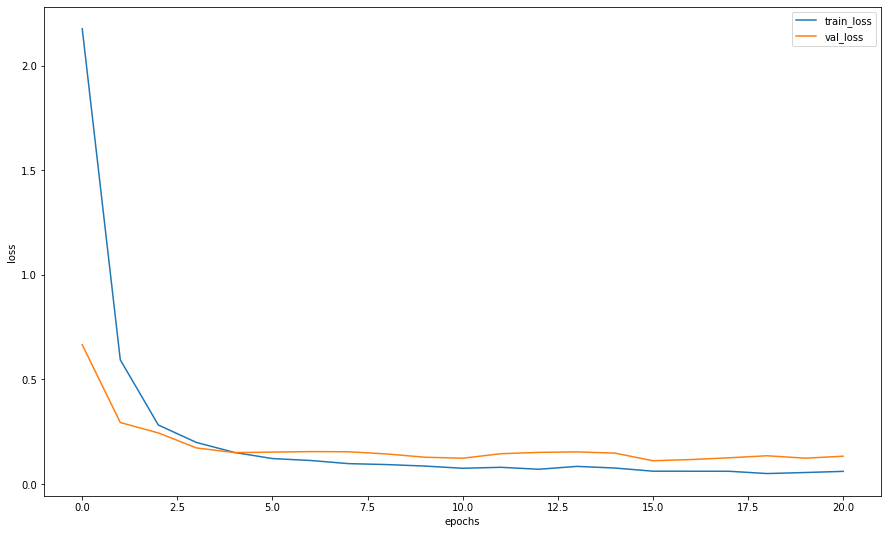

In [49]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

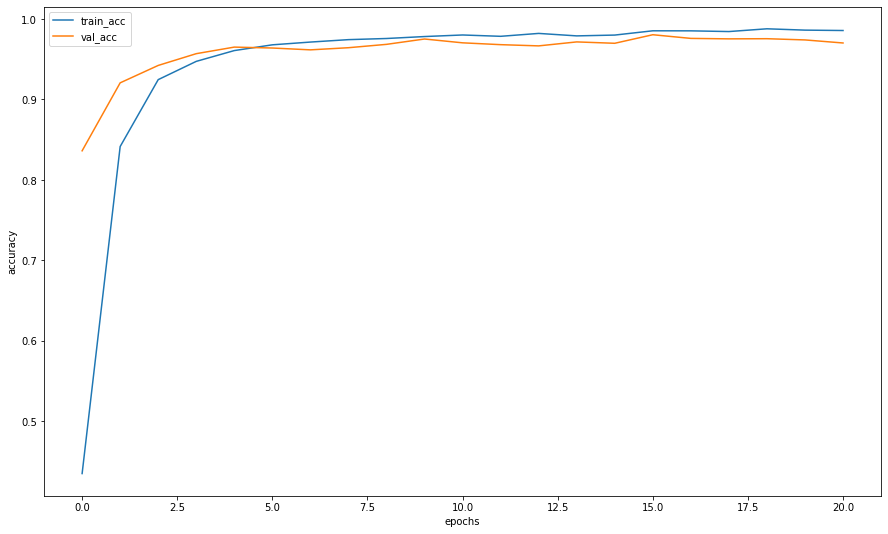

In [50]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [51]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
# random_characters = int(np.random.uniform(0,1000))
# ex_img, true_label = val_dataset[random_characters]

# probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
#probs_im

In [52]:
#idxs = list(map(int, np.random.uniform(0, 1000, 20)))
idxs = list(range(len(val_files)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [53]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
#label_encoder.inverse_transform([val_dataset[0][1]])[0] 

In [54]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.inverse_transform([val_dataset[id][1]])[0] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [55]:
from collections import Counter
import pandas as pd
actual_c = Counter(actual_labels)
actual_pd = pd.DataFrame.from_dict(dict(actual_c), orient='index', columns=['count']).reset_index()
actual_pd = actual_pd.rename(columns={"index": "class"})

for cl in actual_pd['class']:
  aaa = [x if x==cl else 'none' for x in actual_labels]
  acc = 0
  for x, y in zip(aaa, preds_class):
    if x == y:
      acc+=1
  actual_pd.loc[actual_pd['class']  == cl, 'acc'] = acc/actual_pd['count']

actual_pd.to_csv('gdrive/My Drive/datasets/simpsons/data/val_result.csv', index=False)

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [57]:
from sklearn.metrics import f1_score
#preds_class
f1_score(actual_labels, preds_class, average='micro')

0.9701974183750949

In [ ]:
0.971055753262159 inception_v4 lr = 0.00005 new_dataset
0.9702097235462345 inception_v4 lr = 0.00045 new_dataset
0.9752144899904671 inception_v4 lr = 0.00005 new_dataset
0.9636971578695963 densenet121
0.9796990685454979 inception_v4 lr = 0.00005
0.9672796751850967 inception_v4
0.9627418199187963 resnet100
0.9682350131358968 vgg16_bn
0.9615476474802961
0.9584427991401958
0.9441127298781944



0.7980512036683225 val not aug
0.7854413450515858 val also aug
0.7936568589988537 without aug

In [ ]:
 переобучени
 weight decay
 ауги
lr scheduller
batchnorm
size of batch
epoch count
не адам, а что-то другое
Подбирать начальный лр
Другая сеть
Нормализация картинки, что это 
не обрезать картинки

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

findfont: Font family ['roboto'] not found. Falling back to DejaVu Sans.


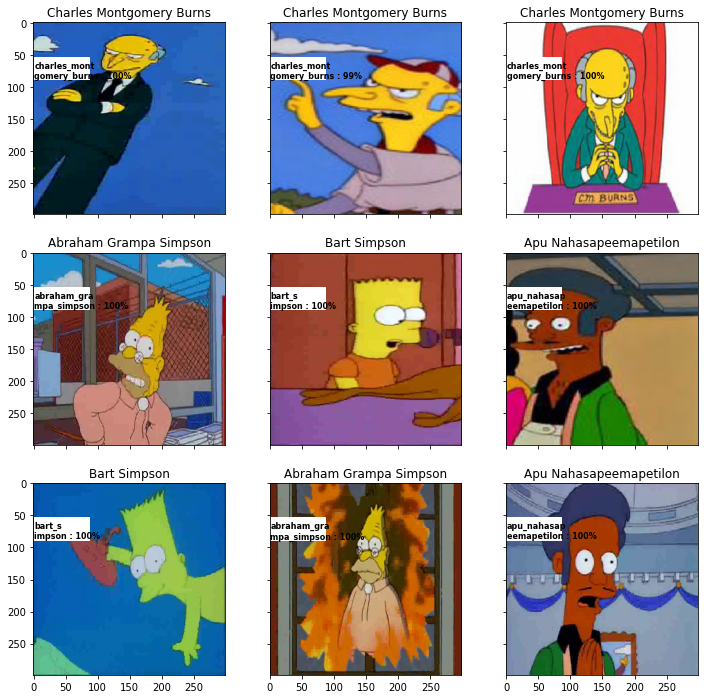

In [58]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("roboto")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [59]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [60]:
! ls 

gdrive	label_encoder.pkl  sample_data	test  train


In [61]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/datasets/simpsons/data/2.txt")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [63]:
my_submit.to_csv('gdrive/My Drive/datasets/simpsons/data/simple_cnn_baseline3.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
